## Redes Neurais Artificiais 2022.2

#### Atividade Avaliativa 2.3

- **Disciplina**: Redes Neurais Artificiais 2022.2

- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)

- **Github**: https://github.com/jo-alves01/rna-aa3


Sobre a base de dados:

O dataset "Maternal Health Risk Data Set" contém informações relacionadas à saúde materna e risco de complicações durante a gestação. As variáveis do conjunto de dados incluem informações como idade, além de dados clínicos, como pressão arterial e níveis de glicose no sangue.

#### Equipe:

Carlos Gabriel da Silva Machado - 1815080079

Davi Rodrigues de França - 1915080053

Gabriella Rabelo Monteiro - 1915080011

Josué Costa dos Santos Alves - 1715080615

Victor Hugo Santos de Lima - 1915080025

## Bibliotecas

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

## Funções úteis

In [36]:
def plot_hist_box(data, col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=col, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=col, ax=ax[1])
    ax[0].set_title(f"Histograma de {col}")
    ax[1].set_title(f"Boxplot de {col}")

    plt.show()

## Leitura do Dataset

In [37]:
mhr_dataset_base = pd.read_csv("./maternal_health_risk_data_set.csv")

In [38]:
mhr_dataset_base.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [39]:
mhr_dataset_base.rename(columns={"BS": "BloodSugar"}, inplace=True)
mhr_dataset_base.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


## Apresentação do dataset

O dataset possui 7 atribuitos no total, sendo eles:


*   **Age**: Idade da mulher;
*   **SystolicBP**: Valor superior da pressão arterial em mmHg;
*   **DiastolicBP**: Valor mais baixo da pressão arterial em mmHg;
*   **BS**: Os níveis de glicose no sangue, em termos de uma concentração molar (mmol/L);
*   **BodyTemp**: Temperatura corporal da mulher (em °F);
*   **HeartRate**: Uma frequência cardíaca normal em repouso em batimentos por minuto;
*   **Risk Level**: Nível de intensidade de risco previsto durante a gravidez.

Os tipos dos dados são: Age: inteiro, SystolicBP: inteiro, DiastolicBP: inteiro, BS: float, BodyTemp: float, HeartRate: inteiro, RiskLevel: objeto.

As informações podem ser observadas abaixo:

In [40]:
mhr_dataset_base.dtypes

Age              int64
SystolicBP       int64
DiastolicBP      int64
BloodSugar     float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

In [41]:
mhr_dataset_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BloodSugar   1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


Verificação da quantidade de exemplos e atributos preditores

In [42]:
columns = len(mhr_dataset_base.axes[1])
rows = len(mhr_dataset_base.axes[0])

print("Quantidade de exemplo:",rows)
print("Quantidade de atributos preditores:",columns-1,)
print("Atributos preditores:",mhr_dataset_base.axes[1][0], mhr_dataset_base.axes[1][1], mhr_dataset_base.axes[1][2], mhr_dataset_base.axes[1][3], mhr_dataset_base.axes[1][4], mhr_dataset_base.axes[1][5])
print("Quantidade de atributos alvo:", columns-(columns-1))
print("Atributo alvo:",mhr_dataset_base.axes[1][6])

Quantidade de exemplo: 1014
Quantidade de atributos preditores: 6
Atributos preditores: Age SystolicBP DiastolicBP BloodSugar BodyTemp HeartRate
Quantidade de atributos alvo: 1
Atributo alvo: RiskLevel


Checando se existem dados faltantes no dataset:

In [43]:
mhr_dataset_base.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BloodSugar     0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

Verificando quantos exemplos existem para cada classe do atributo alvo:

In [44]:
mhr_dataset_base['RiskLevel'].value_counts()

low risk     406
mid risk     336
high risk    272
Name: RiskLevel, dtype: int64

Abaixo pode-se observar alguns dados gerais sobre o dataset:

In [45]:
mhr_dataset_base.describe()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


Abaixo é possível observar a distribuição dos dados dentro do dataset

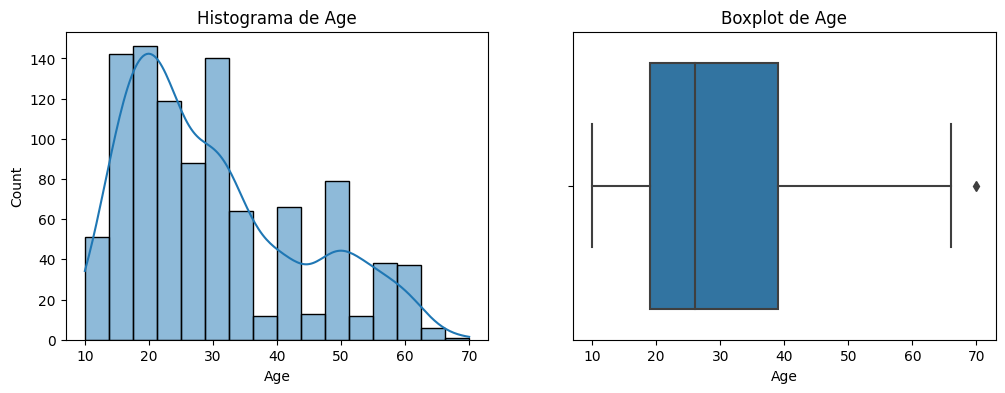

In [46]:
plot_hist_box(mhr_dataset_base, 'Age')

É possível observar que o atributo Age possui sua mediana em torno de 26 anos e que existem muitos exemplos entre os valores de 20 até 35 anos, enquanto valores maiores e menores que esse intervalo possuem poucos exemplos.

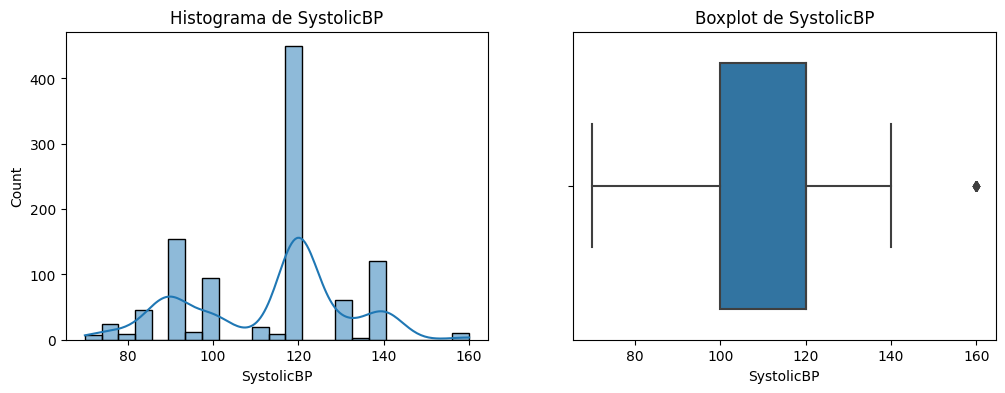

In [47]:
plot_hist_box(mhr_dataset_base, 'SystolicBP')

Ao examinar os gráficos acima, pode-se afirmar que a mediana do atributo SystolicBP é em torno de 120, com uma grande quantidade de exemplos na faixa de 100 até 120, além de verificar um pequeno grupo de exemplos entre os valores de 80 até 100, e entre 130 até 140. É também visível um *outlier* no valor 160.

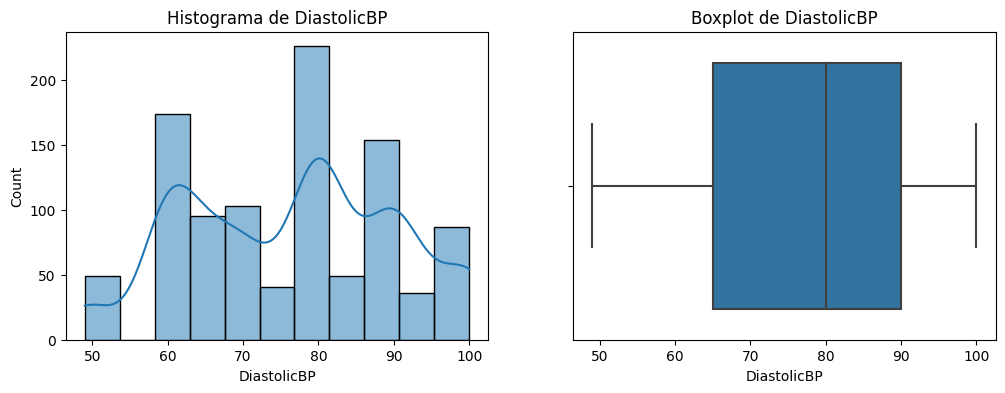

In [48]:
plot_hist_box(mhr_dataset_base, 'DiastolicBP')

O atributo DiastolicBP possui sua mediana em 80, com exemplos relativamente bem distribuídos, principalmente na faixa entre 65 e 90.

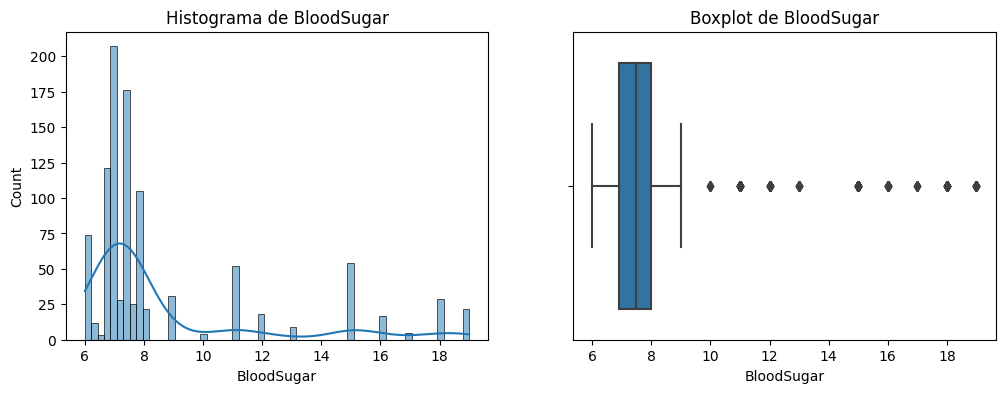

In [49]:
plot_hist_box(mhr_dataset_base, 'BloodSugar')

Diferente do atributo DiastolicBP, o atributo BloodSugar possui exemplos dispersos, com sua grande maioria entre os valores de 7 e 8, sua mediana é em torno de 7,5. É bastante visível os diversos *outliers* existentes neste atributo.

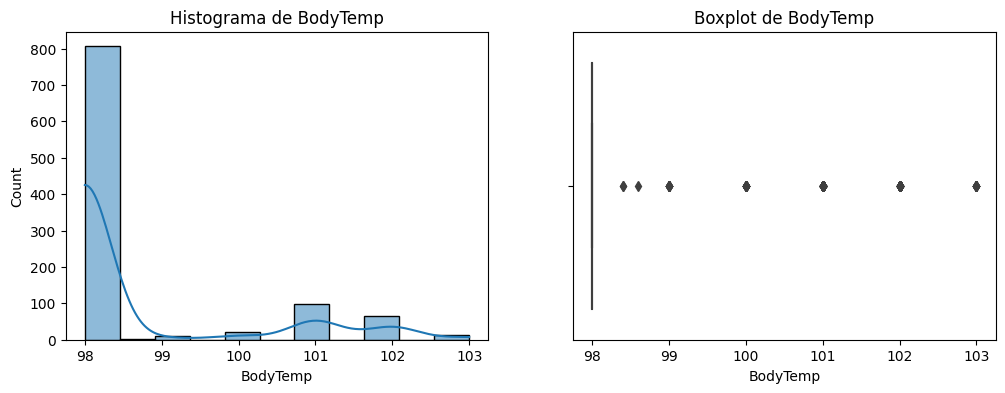

In [50]:
plot_hist_box(mhr_dataset_base, 'BodyTemp')

É notável a dispariedade dos valores dos exemplos do atributo BodyTemp, com sua mediana e a maioria dos exemplos com valor 98, e os outro valores sendo considerados quase *outliers*, apesar de estarem próximo do valor 98.

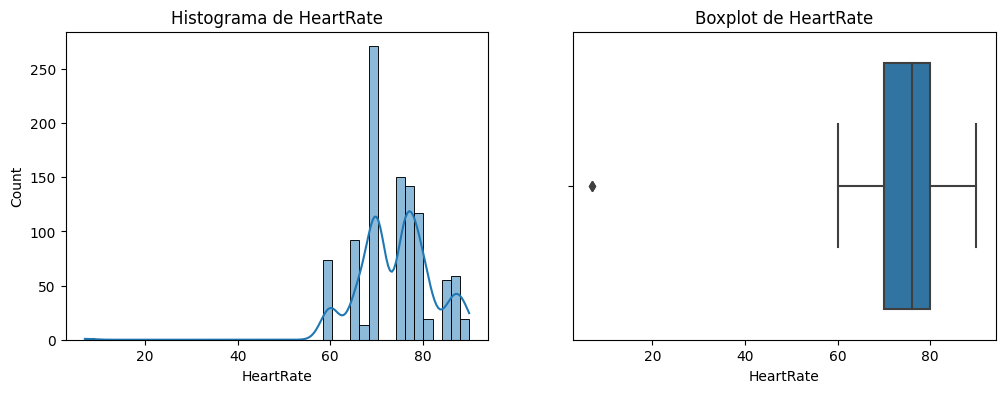

In [51]:
plot_hist_box(mhr_dataset_base, 'HeartRate')

Por último, o atributo HeartRate possui a maioria dos seus exemplos entre 70 e 80, e sua mediana é de aproximadamente 75. É possível obervar a existência de um *outlier* próximo do valor 10.

## Preparação dos dados

### Categorização dos dados

## Separando a base de dados em atributos preditores e alvos

In [52]:
X = mhr_dataset_base.drop(columns=["RiskLevel"],axis=1)
y = mhr_dataset_base["RiskLevel"]

## Realizando a normalização dos dados

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train_norm = (X_train - X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))
X_test_norm = (X_test - X_test.min(axis=0))/(X_test.max(axis=0) - X_test.min(axis=0))

## GridSearch

In [54]:
mlp = MLPClassifier(activation='relu',learning_rate="adaptive", momentum=0.4 ,solver='adam', max_iter=300,verbose=False, random_state=42)

In [55]:
pipe = Pipeline([('mlp', mlp)])
param_grid = {
    'mlp__hidden_layer_sizes': [[5,7],[9,8]],
    'mlp__activation': ["logistic", "relu"],
    'mlp__solver': ['adam', "lbfgs"],
    'mlp__batch_size': [16, 32],
    'mlp__beta_1': [0.999, 0.9, 0.8],
    'mlp__beta_2': [0.999, 0.95, 0.9],
    'mlp__n_iter_no_change': [25, 50],
}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='recall_macro', n_jobs=-1, verbose=False)

In [56]:
grid.fit(X_train_norm,y_train)

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptr

GridSearchCV(estimator=Pipeline(steps=[('mlp',
                                        MLPClassifier(learning_rate='adaptive',
                                                      max_iter=300,
                                                      momentum=0.4,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['logistic', 'relu'],
                         'mlp__batch_size': [16, 32],
                         'mlp__beta_1': [0.999, 0.9, 0.8],
                         'mlp__beta_2': [0.999, 0.95, 0.9],
                         'mlp__hidden_layer_sizes': [[5, 7], [9, 8]],
                         'mlp__n_iter_no_change': [25, 50],
                         'mlp__solver': ['adam', 'lbfgs']},
             scoring='recall_macro', verbose=False)

In [57]:
for i in sklearn.metrics.get_scorer_names():
    if "recall" in i:
        print(i)

recall
recall_macro
recall_micro
recall_samples
recall_weighted


In [58]:
top_3 = pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score", ignore_index=True)[:3]
top_3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__batch_size,param_mlp__beta_1,param_mlp__beta_2,param_mlp__hidden_layer_sizes,param_mlp__n_iter_no_change,param_mlp__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.485703,0.148551,0.007589,0.001751,relu,16,0.8,0.999,"[5, 7]",25,adam,"{'mlp__activation': 'relu', 'mlp__batch_size':...",0.725235,0.711435,0.695481,0.691394,0.641955,0.693100,0.02826,1
1,8.316818,0.285684,0.005884,0.000465,relu,16,0.8,0.999,"[5, 7]",50,adam,"{'mlp__activation': 'relu', 'mlp__batch_size':...",0.725235,0.711435,0.695481,0.691394,0.641955,0.693100,0.02826,1
2,8.393943,0.455694,0.006301,0.000578,relu,16,0.9,0.999,"[5, 7]",25,adam,"{'mlp__activation': 'relu', 'mlp__batch_size':...",0.707811,0.711435,0.698281,0.697141,0.646244,0.692182,0.02361,3


In [59]:
mlp1 = MLPClassifier(activation=top_3.param_mlp__activation[0], solver=top_3.param_mlp__solver[0], hidden_layer_sizes=top_3.param_mlp__hidden_layer_sizes[0], learning_rate_init=0.001, beta_1=top_3.param_mlp__beta_1[0], beta_2=top_3.param_mlp__beta_2[0], max_iter=600, n_iter_no_change=top_3.param_mlp__n_iter_no_change[0], verbose=True, random_state=42)
h1 = mlp1.fit(X_train_norm, y_train)

mlp2 = MLPClassifier(activation=top_3.param_mlp__activation[1], solver=top_3.param_mlp__solver[1], hidden_layer_sizes=top_3.param_mlp__hidden_layer_sizes[1], learning_rate_init=0.001, beta_1=top_3.param_mlp__beta_1[1], beta_2=top_3.param_mlp__beta_2[1], max_iter=600, n_iter_no_change=top_3.param_mlp__n_iter_no_change[1], verbose=True, random_state=42)
h2 = mlp2.fit(X_train_norm, y_train)

mlp3 = MLPClassifier(activation=top_3.param_mlp__activation[2], solver=top_3.param_mlp__solver[2], hidden_layer_sizes=top_3.param_mlp__hidden_layer_sizes[2], learning_rate_init=0.001, beta_1=top_3.param_mlp__beta_1[2], beta_2=top_3.param_mlp__beta_2[2], max_iter=600, n_iter_no_change=top_3.param_mlp__n_iter_no_change[2], verbose=True, random_state=42)
h3 = mlp3.fit(X_train_norm, y_train)

Iteration 1, loss = 1.10150669
Iteration 2, loss = 1.09817406
Iteration 3, loss = 1.09536554
Iteration 4, loss = 1.09272306
Iteration 5, loss = 1.09008860
Iteration 6, loss = 1.08773050
Iteration 7, loss = 1.08554674
Iteration 8, loss = 1.08349091
Iteration 9, loss = 1.08171336
Iteration 10, loss = 1.08001476
Iteration 11, loss = 1.07842986
Iteration 12, loss = 1.07709684
Iteration 13, loss = 1.07561331
Iteration 14, loss = 1.07417496
Iteration 15, loss = 1.07278128
Iteration 16, loss = 1.07119428
Iteration 17, loss = 1.06951022
Iteration 18, loss = 1.06802632
Iteration 19, loss = 1.06628944
Iteration 20, loss = 1.06471792
Iteration 21, loss = 1.06287065
Iteration 22, loss = 1.06108867
Iteration 23, loss = 1.05918285
Iteration 24, loss = 1.05715445
Iteration 25, loss = 1.05509019
Iteration 26, loss = 1.05282466
Iteration 27, loss = 1.05064695
Iteration 28, loss = 1.04824026
Iteration 29, loss = 1.04606560
Iteration 30, loss = 1.04372180
Iteration 31, loss = 1.04143892
Iteration 32, los

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 54, loss = 0.93642805
Iteration 55, loss = 0.93298449
Iteration 56, loss = 0.92952103
Iteration 57, loss = 0.92638236
Iteration 58, loss = 0.92329953
Iteration 59, loss = 0.92047973
Iteration 60, loss = 0.91771995
Iteration 61, loss = 0.91455053
Iteration 62, loss = 0.91189326
Iteration 63, loss = 0.90912726
Iteration 64, loss = 0.90667613
Iteration 65, loss = 0.90406190
Iteration 66, loss = 0.90186008
Iteration 67, loss = 0.89912275
Iteration 68, loss = 0.89663860
Iteration 69, loss = 0.89427845
Iteration 70, loss = 0.89209117
Iteration 71, loss = 0.88981718
Iteration 72, loss = 0.88757263
Iteration 73, loss = 0.88542751
Iteration 74, loss = 0.88345088
Iteration 75, loss = 0.88141500
Iteration 76, loss = 0.87934854
Iteration 77, loss = 0.87723228
Iteration 78, loss = 0.87558910
Iteration 79, loss = 0.87339644
Iteration 80, loss = 0.87136988
Iteration 81, loss = 0.86955409
Iteration 82, loss = 0.86773883
Iteration 83, loss = 0.86593689
Iteration 84, loss = 0.86418494
Iteratio

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 80, loss = 0.87569290
Iteration 81, loss = 0.87375095
Iteration 82, loss = 0.87183381
Iteration 83, loss = 0.86988706
Iteration 84, loss = 0.86791524
Iteration 85, loss = 0.86624276
Iteration 86, loss = 0.86426095
Iteration 87, loss = 0.86251564
Iteration 88, loss = 0.86072488
Iteration 89, loss = 0.85899721
Iteration 90, loss = 0.85731742
Iteration 91, loss = 0.85558487
Iteration 92, loss = 0.85391181
Iteration 93, loss = 0.85241108
Iteration 94, loss = 0.85065256
Iteration 95, loss = 0.84915329
Iteration 96, loss = 0.84759210
Iteration 97, loss = 0.84613546
Iteration 98, loss = 0.84464627
Iteration 99, loss = 0.84315474
Iteration 100, loss = 0.84170800
Iteration 101, loss = 0.84029065
Iteration 102, loss = 0.83883431
Iteration 103, loss = 0.83746880
Iteration 104, loss = 0.83624825
Iteration 105, loss = 0.83504229
Iteration 106, loss = 0.83363600
Iteration 107, loss = 0.83236198
Iteration 108, loss = 0.83102189
Iteration 109, loss = 0.82976261
Iteration 110, loss = 0.828557

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


## Matriz Confusão

In [60]:
def plot_cf(cf1):

    try:
        fig, ax = plt.subplots()
        risks = mhr_dataset_base["RiskLevel"].unique()
        im = ax.imshow(cf1)
        ax.set_xticks(np.arange(len(risks)), labels=risks)
        ax.set_yticks(np.arange(len(risks)), labels=risks)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        for i in range(len(risks)):
            for j in range(len(risks)):
                ax.text(j, i, cf1[i, j], ha="center", va="center", color="w")
        
        ax.set_title("")
        plt.show()
    except Exception as e:
        print(e)

Para o modelo 1

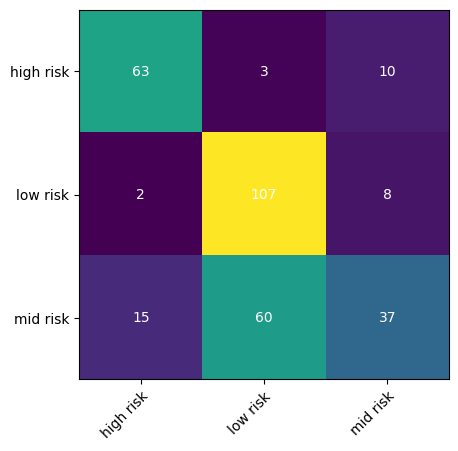

Revocação para MLP1:  0.6786885245901639


In [66]:
test_predictions1 = h1.predict(X_test_norm)
cf1 = confusion_matrix(y_test, test_predictions1)
plot_cf(cf1)
print('Revocação para MLP1: ',recall_score(y_test, test_predictions1,average='weighted'))

Para o modelo 2

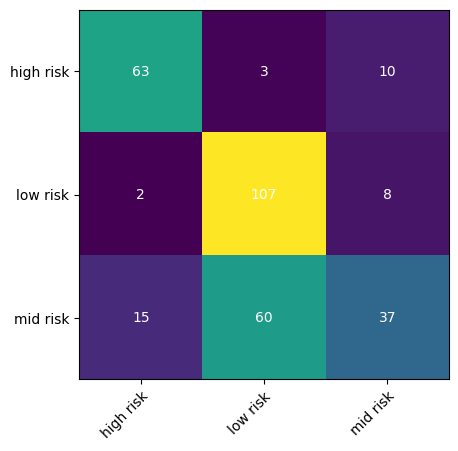

Revocação para MLP2:  0.6786885245901639


In [67]:
test_predictions2 = h2.predict(X_test_norm)
cf2 = confusion_matrix(y_test, test_predictions2)
plot_cf(cf2)
print('Revocação para MLP2: ', recall_score(y_test, test_predictions2,average='weighted'))

Para o modelo 3

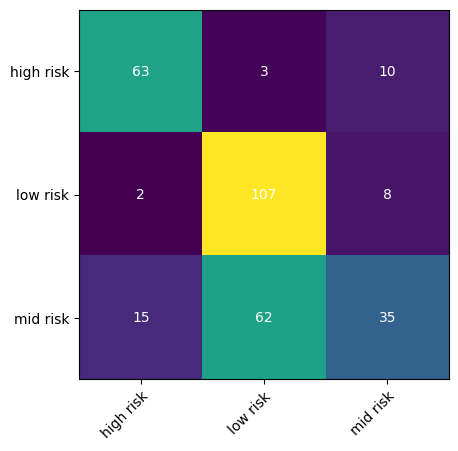

Revocação para MLP3:  0.6721311475409836


In [68]:
test_predictions3 = h3.predict(X_test_norm)
cf3 = confusion_matrix(y_test, test_predictions3)
plot_cf(cf3)
print('Revocação para MLP3: ', recall_score(y_test, test_predictions3,average='weighted'))

## K-FOLD

In [64]:
kfold = KFold(n_splits=3,shuffle=True)
result1 = cross_val_score(mlp1, X_test_norm, y_test, cv = kfold, scoring='recall_micro')
result2 = cross_val_score(mlp2, X_test_norm, y_test, cv = kfold, scoring='recall_micro')
result3 = cross_val_score(mlp3, X_test_norm, y_test, cv = kfold, scoring='recall_micro')

Iteration 1, loss = 1.09180284
Iteration 2, loss = 1.09103236
Iteration 3, loss = 1.09063217
Iteration 4, loss = 1.09023645
Iteration 5, loss = 1.08978179
Iteration 6, loss = 1.08937328
Iteration 7, loss = 1.08891773
Iteration 8, loss = 1.08854761
Iteration 9, loss = 1.08823700
Iteration 10, loss = 1.08782707
Iteration 11, loss = 1.08747549
Iteration 12, loss = 1.08704647
Iteration 13, loss = 1.08658743
Iteration 14, loss = 1.08621590
Iteration 15, loss = 1.08584711
Iteration 16, loss = 1.08551590
Iteration 17, loss = 1.08519090
Iteration 18, loss = 1.08485578
Iteration 19, loss = 1.08451326
Iteration 20, loss = 1.08418201
Iteration 21, loss = 1.08382456
Iteration 22, loss = 1.08343613
Iteration 23, loss = 1.08319336
Iteration 24, loss = 1.08290309
Iteration 25, loss = 1.08259135
Iteration 26, loss = 1.08228766
Iteration 27, loss = 1.08206165
Iteration 28, loss = 1.08179254
Iteration 29, loss = 1.08148734
Iteration 30, loss = 1.08123694
Iteration 31, loss = 1.08095848
Iteration 32, los

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 216, loss = 0.97352804
Iteration 217, loss = 0.97304648
Iteration 218, loss = 0.97261900
Iteration 219, loss = 0.97222569
Iteration 220, loss = 0.97160846
Iteration 221, loss = 0.97099539
Iteration 222, loss = 0.97040897
Iteration 223, loss = 0.96982439
Iteration 224, loss = 0.96931666
Iteration 225, loss = 0.96889277
Iteration 226, loss = 0.96837573
Iteration 227, loss = 0.96794640
Iteration 228, loss = 0.96762199
Iteration 229, loss = 0.96731641
Iteration 230, loss = 0.96694519
Iteration 231, loss = 0.96669407
Iteration 232, loss = 0.96627280
Iteration 233, loss = 0.96586545
Iteration 234, loss = 0.96547670
Iteration 235, loss = 0.96497854
Iteration 236, loss = 0.96434558
Iteration 237, loss = 0.96380645
Iteration 238, loss = 0.96319575
Iteration 239, loss = 0.96258683
Iteration 240, loss = 0.96218986
Iteration 241, loss = 0.96164270
Iteration 242, loss = 0.96109166
Iteration 243, loss = 0.96063816
Iteration 244, loss = 0.96018532
Iteration 245, loss = 0.95960482
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 172, loss = 0.98572099
Iteration 173, loss = 0.98422675
Iteration 174, loss = 0.98278994
Iteration 175, loss = 0.98158762
Iteration 176, loss = 0.98045968
Iteration 177, loss = 0.97923656
Iteration 178, loss = 0.97790705
Iteration 179, loss = 0.97663377
Iteration 180, loss = 0.97544564
Iteration 181, loss = 0.97409383
Iteration 182, loss = 0.97259419
Iteration 183, loss = 0.97087257
Iteration 184, loss = 0.96898636
Iteration 185, loss = 0.96728222
Iteration 186, loss = 0.96543522
Iteration 187, loss = 0.96347224
Iteration 188, loss = 0.96174922
Iteration 189, loss = 0.96019777
Iteration 190, loss = 0.95870348
Iteration 191, loss = 0.95722127
Iteration 192, loss = 0.95589856
Iteration 193, loss = 0.95455331
Iteration 194, loss = 0.95302358
Iteration 195, loss = 0.95129448
Iteration 196, loss = 0.94928346
Iteration 197, loss = 0.94710707
Iteration 198, loss = 0.94514200
Iteration 199, loss = 0.94318388
Iteration 200, loss = 0.94184181
Iteration 201, loss = 0.94050897
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 272, loss = 0.98588026
Iteration 273, loss = 0.98521251
Iteration 274, loss = 0.98416197
Iteration 275, loss = 0.98305014
Iteration 276, loss = 0.98218292
Iteration 277, loss = 0.98144094
Iteration 278, loss = 0.98085875
Iteration 279, loss = 0.98058635
Iteration 280, loss = 0.98036937
Iteration 281, loss = 0.98032732
Iteration 282, loss = 0.98007351
Iteration 283, loss = 0.97949561
Iteration 284, loss = 0.97886258
Iteration 285, loss = 0.97834889
Iteration 286, loss = 0.97765171
Iteration 287, loss = 0.97672554
Iteration 288, loss = 0.97606968
Iteration 289, loss = 0.97582807
Iteration 290, loss = 0.97555069
Iteration 291, loss = 0.97524731
Iteration 292, loss = 0.97446037
Iteration 293, loss = 0.97361776
Iteration 294, loss = 0.97306758
Iteration 295, loss = 0.97236207
Iteration 296, loss = 0.97158757
Iteration 297, loss = 0.97076054
Iteration 298, loss = 0.96978449
Iteration 299, loss = 0.96889721
Iteration 300, loss = 0.96808976
Iteration 301, loss = 0.96730825
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 240, loss = 0.91906921
Iteration 241, loss = 0.91860312
Iteration 242, loss = 0.91831420
Iteration 243, loss = 0.91765511
Iteration 244, loss = 0.91644702
Iteration 245, loss = 0.91527466
Iteration 246, loss = 0.91419496
Iteration 247, loss = 0.91316731
Iteration 248, loss = 0.91210061
Iteration 249, loss = 0.91130520
Iteration 250, loss = 0.91068185
Iteration 251, loss = 0.91010503
Iteration 252, loss = 0.90960220
Iteration 253, loss = 0.90895457
Iteration 254, loss = 0.90827118
Iteration 255, loss = 0.90761063
Iteration 256, loss = 0.90660033
Iteration 257, loss = 0.90559961
Iteration 258, loss = 0.90484391
Iteration 259, loss = 0.90431945
Iteration 260, loss = 0.90354090
Iteration 261, loss = 0.90260606
Iteration 262, loss = 0.90207078
Iteration 263, loss = 0.90160227
Iteration 264, loss = 0.90138546
Iteration 265, loss = 0.90161739
Iteration 266, loss = 0.90200461
Iteration 267, loss = 0.90234753
Iteration 268, loss = 0.90288893
Iteration 269, loss = 0.90244509
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 207, loss = 0.98300946
Iteration 208, loss = 0.98243716
Iteration 209, loss = 0.98168405
Iteration 210, loss = 0.98062654
Iteration 211, loss = 0.97949221
Iteration 212, loss = 0.97851057
Iteration 213, loss = 0.97755087
Iteration 214, loss = 0.97660371
Iteration 215, loss = 0.97559231
Iteration 216, loss = 0.97458050
Iteration 217, loss = 0.97347220
Iteration 218, loss = 0.97236478
Iteration 219, loss = 0.97115657
Iteration 220, loss = 0.96979166
Iteration 221, loss = 0.96848814
Iteration 222, loss = 0.96752217
Iteration 223, loss = 0.96672916
Iteration 224, loss = 0.96586056
Iteration 225, loss = 0.96509161
Iteration 226, loss = 0.96441626
Iteration 227, loss = 0.96358112
Iteration 228, loss = 0.96282930
Iteration 229, loss = 0.96201604
Iteration 230, loss = 0.96106043
Iteration 231, loss = 0.96019291
Iteration 232, loss = 0.95944610
Iteration 233, loss = 0.95858892
Iteration 234, loss = 0.95752623
Iteration 235, loss = 0.95653738
Iteration 236, loss = 0.95557506
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 160, loss = 1.03078284
Iteration 161, loss = 1.03000434
Iteration 162, loss = 1.02924377
Iteration 163, loss = 1.02855722
Iteration 164, loss = 1.02788273
Iteration 165, loss = 1.02723913
Iteration 166, loss = 1.02673035
Iteration 167, loss = 1.02622450
Iteration 168, loss = 1.02581082
Iteration 169, loss = 1.02536163
Iteration 170, loss = 1.02488081
Iteration 171, loss = 1.02440281
Iteration 172, loss = 1.02387155
Iteration 173, loss = 1.02324713
Iteration 174, loss = 1.02255790
Iteration 175, loss = 1.02188548
Iteration 176, loss = 1.02118182
Iteration 177, loss = 1.02048122
Iteration 178, loss = 1.01983954
Iteration 179, loss = 1.01922368
Iteration 180, loss = 1.01868169
Iteration 181, loss = 1.01833094
Iteration 182, loss = 1.01790363
Iteration 183, loss = 1.01744186
Iteration 184, loss = 1.01691734
Iteration 185, loss = 1.01636972
Iteration 186, loss = 1.01585194
Iteration 187, loss = 1.01534563
Iteration 188, loss = 1.01491408
Iteration 189, loss = 1.01444845
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 262, loss = 1.00814960
Iteration 263, loss = 1.00757062
Iteration 264, loss = 1.00695448
Iteration 265, loss = 1.00630383
Iteration 266, loss = 1.00559219
Iteration 267, loss = 1.00483863
Iteration 268, loss = 1.00431287
Iteration 269, loss = 1.00382719
Iteration 270, loss = 1.00339241
Iteration 271, loss = 1.00300870
Iteration 272, loss = 1.00256183
Iteration 273, loss = 1.00216691
Iteration 274, loss = 1.00180550
Iteration 275, loss = 1.00134176
Iteration 276, loss = 1.00070396
Iteration 277, loss = 0.99993264
Iteration 278, loss = 0.99915608
Iteration 279, loss = 0.99835343
Iteration 280, loss = 0.99759603
Iteration 281, loss = 0.99687528
Iteration 282, loss = 0.99618482
Iteration 283, loss = 0.99550849
Iteration 284, loss = 0.99486420
Iteration 285, loss = 0.99428026
Iteration 286, loss = 0.99375789
Iteration 287, loss = 0.99328695
Iteration 288, loss = 0.99282812
Iteration 289, loss = 0.99236724
Iteration 290, loss = 0.99189030
Iteration 291, loss = 0.99138786
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 217, loss = 0.89751246
Iteration 218, loss = 0.89658548
Iteration 219, loss = 0.89561671
Iteration 220, loss = 0.89459430
Iteration 221, loss = 0.89373853
Iteration 222, loss = 0.89281472
Iteration 223, loss = 0.89187566
Iteration 224, loss = 0.89086868
Iteration 225, loss = 0.88988519
Iteration 226, loss = 0.88889294
Iteration 227, loss = 0.88806518
Iteration 228, loss = 0.88715346
Iteration 229, loss = 0.88637267
Iteration 230, loss = 0.88575291
Iteration 231, loss = 0.88506475
Iteration 232, loss = 0.88441799
Iteration 233, loss = 0.88398843
Iteration 234, loss = 0.88343571
Iteration 235, loss = 0.88291424
Iteration 236, loss = 0.88222791
Iteration 237, loss = 0.88159771
Iteration 238, loss = 0.88110281
Iteration 239, loss = 0.88043668
Iteration 240, loss = 0.87970455
Iteration 241, loss = 0.87891688
Iteration 242, loss = 0.87806024
Iteration 243, loss = 0.87729944
Iteration 244, loss = 0.87659766
Iteration 245, loss = 0.87597439
Iteration 246, loss = 0.87530064
Iteration 

/home/lse/Documentos/codigos/rna/rna-aa3/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


In [65]:
print(f"Resultado para mlp1: {result1}")
print(f"Resultado para mlp2: {result2}")
print(f"Resultado para mlp3: {result3}")

Resultado para mlp1: [0.55882353 0.46078431 0.54455446]
Resultado para mlp2: [0.53921569 0.54901961 0.53465347]
Resultado para mlp3: [0.58823529 0.56862745 0.52475248]
